In [107]:
# Initialization
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.utils import np_utils # one-hot-encoding

# Required for loss function
import math
from tensorflow.python.keras import losses

import tensorflow as tf

In [2]:
# Set someparameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
# Original size = 572*572
IMG_CHANNELS = 3

MODEL_NAME = 'model-lab-unet-scratch.h5'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [3]:
# Import the data
# Path for Linux
#TRAIN_PATH = '/home/ziheng/UNet/dataset_lab/train/'
#TEST_PATH = '/home/ziheng/UNet/dataset_lab/test/'

# Path for Windows
#TRAIN_PATH = 'F:\\MA\\data\\dataset_lab\\train\\'
TEST_PATH = 'F:\MA\\data\\dataset_lab\\test\\'

# Get train and test IDs
#train_ids = next(os.walk(TRAIN_PATH + 'in/'))[2]
test_ids = next(os.walk(TEST_PATH + 'in/'))[2]

# Get and resize train images and masks
# X_train: original images
#X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
# Y_train: masks
#Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

# X_train: original images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
# Y_train: masks
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)


'''
print('Getting and resizing train images and masks ... ')

sys.stdout.flush()


for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    img = imread(TRAIN_PATH + 'in/' + id_)
    img = img[:,:,np.newaxis]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
    X_train[n] = img
    #mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)
    mask = imread(TRAIN_PATH + 'out-cell/' + id_.replace('.jpg', '.png'))
    #mask = mask[:,:,np.newaxis]
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    mask = np_utils.to_categorical(mask, IMG_CHANNELS) # Generate binary masks (one hot encoding)
    Y_train[n] = mask
'''    
    
    
# Get and resize test images
#X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
#    path = TEST_PATH + id_
    img = imread(TEST_PATH + 'in/' + id_)
    img = img[:,:,np.newaxis]
#    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
    X_test[n] = img
    mask = imread(TEST_PATH + 'out-cell/' + id_.replace('.jpg', '.png'))
    mask = mask[:,:,np.newaxis]
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    mask = np_utils.to_categorical(mask, IMG_CHANNELS) # Generate binary masks (one hot encoding)
    Y_test[n] = mask
    

print('Done!')

Getting and resizing test images ... 


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 35.10it/s]


Done!


In [4]:
def IoU(y_true,y_pred):
    y_true_f = tf.reshape(y_true,[-1])
    y_pred_f = tf.reshape(y_pred,[-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = intersection / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f))
    return score

def IoU_loss(y_true , y_pred):
    loss = 1 - IoU(y_true, y_pred)
    return loss

In [5]:
# Define custom metrics and loss functions
def dice_coeff(y_true,y_pred):
    smooth = 1.
    y_true_f = tf.reshape(y_true,[-1])
    y_pred_f = tf.reshape(y_pred,[-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true , y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss (y_true, y_pred):
    loss = losses.categorical_crossentropy(y_true,y_pred)+dice_loss(y_true,y_pred)
    return loss

# The same as log_loss
def mlogloss(target, pred):
    score = 0.0
    for i in range(len(pred)):
        pp = pred[i]
        for j in range(len(pp)):
            prob = pp[j]
            if prob < 1e-15:
                prob = 1e-15
            score += target[i][j] * math.log(prob)
    return -score/len(pred)

In [6]:
# Predict on train, val and test
model = load_model('.\\model\\' + MODEL_NAME, custom_objects={'bce_dice_loss': IoU_loss, 'IoU': IoU, 'dice_loss': dice_loss})
#preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
#preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
#preds_train_t = (preds_train > 0.5).astype(np.uint8)
#preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
#for i in range(len(preds_test)):
#    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
#                                       (sizes_test[i][0], sizes_test[i][1]), 
#                                       mode='constant', preserve_range=True))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
34/34 [==============================] - ETA:  - 2s 56ms/step


In [17]:
print(preds_test_t.shape)

(34, 128, 128, 3)


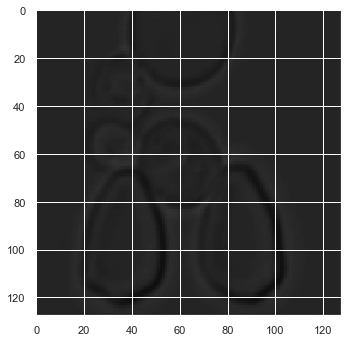

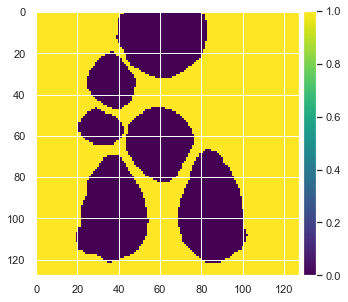

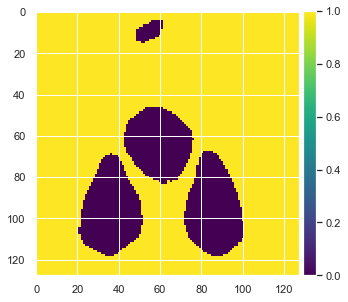

In [184]:
# Perform a test on prediction result
#ix = random.randint(0, len(test_ids))
ix = 25
mask_category = 0 # Choose the mask nummer 0,1,2
imshow(np.reshape(X_test[ix], (IMG_WIDTH, IMG_HEIGHT)))
plt.show()
imshow(np.squeeze(Y_test[ix,:,:,mask_category])) 
plt.show()
imshow(np.squeeze(preds_test_t[ix,:,:,mask_category]))
plt.show()

In [9]:
# Generate the mask wihtout one-hot-encoding 
preds_test_mask = np.zeros(shape=(preds_test_t.shape[0], preds_test_t.shape[1], preds_test_t.shape[2]))

for i in range(preds_test_t.shape[0]):
    for y in range(preds_test_t.shape[1]):
        for x in range(preds_test_t.shape[2]):
            if preds_test_t[i, y, x, 1] == 1:
                preds_test_mask[i, y, x] = 1
            elif preds_test_t[i, y, x, 2] == 1:
                preds_test_mask[i, y, x] = 2
            else:
                preds_test_mask[i, y, x] = 0

25


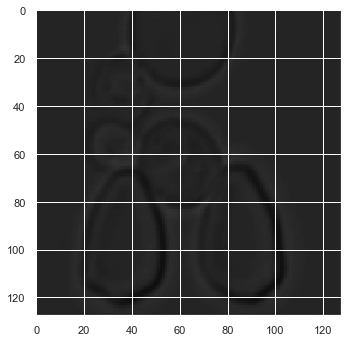

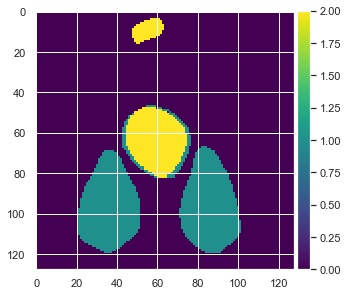

In [139]:
# Generate and show the test image + the prediction masks
#ix = random.randint(0, len(test_ids))
ix = 25
print(ix)

imshow(np.reshape(X_test[ix], (IMG_WIDTH, IMG_HEIGHT)))
plt.show()

imshow(np.squeeze(preds_test_mask[ix]))
plt.show()

11


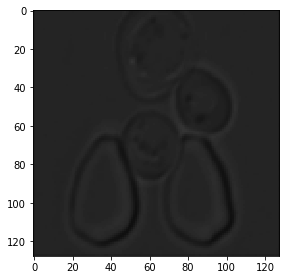

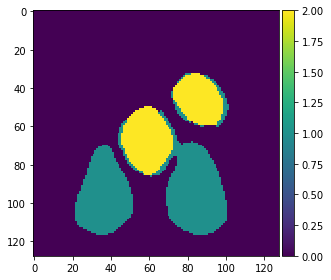

In [11]:
################### Don't run unless you want to generate images!!!!!!! ######################
##############################################################################################
# Generate and save the test image + the prediction masks
#ix = random.randint(0, len(test_ids))
ix = 11
print(ix)
plt.figure()
imshow(np.reshape(X_test[ix], (IMG_WIDTH, IMG_HEIGHT)))
#plt.show()
plt.savefig('test_img_' + str(ix) + '.png')
#imshow(np.squeeze(Y_test[ix,:,:,mask_category])) 
#plt.show()
plt.figure()
imshow(np.squeeze(preds_test_mask[ix]))
#plt.show()
plt.savefig('preds_mask_' + str(ix) + '.png')

In [180]:
# Define evaluation metrics
def metric_IoU(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    return np.sum(intersection) / np.sum(union)

def metric_precision(target, prediction):
    target_bool = np.array(target, dtype = 'bool')
    prediction_bool = np.array(prediction, dtype = 'bool')
    TP = np.logical_and(target_bool, prediction_bool)
    FP = np.logical_and(~target_bool, prediction_bool)
    return np.sum(TP) / (np.sum(TP)+np.sum(FP))    
    
def metric_recall(target, prediction):
    target_bool = np.array(target, dtype = 'bool')
    prediction_bool = np.array(prediction, dtype = 'bool')
    TP = np.logical_and(target_bool, prediction_bool)
    FN = np.logical_and(target_bool, ~prediction_bool)
    return np.sum(TP) / (np.sum(TP)+np.sum(FN))
    
def metric_f1(target, prediction):
    precision = metric_precision(target, prediction)
    recall = metric_recall(target, prediction)
    return 2*precision*recall/(precision+recall)

In [190]:
IoU_score = []
class_IoU_score = []
class_f1_score = []
class_precision_score = []
class_recall_score =  []

for d in range(Y_test.shape[3]):
    class_IoU_score.append([])
    class_f1_score.append([])
    class_precision_score.append([])
    class_recall_score.append([])

for i in range(len(X_test)):
    IoU_score.append(metric_IoU(Y_test[i], preds_test_t[i]))
    for d in range(Y_test.shape[3]):
        class_IoU_score[d].append(metric_IoU(Y_test[i,:,:,d], preds_test_t[i,:,:,d]))
        class_f1_score[d].append(metric_f1(Y_test[i,:,:,d], preds_test_t[i,:,:,d]))
        class_precision_score[d].append(metric_precision(Y_test[i,:,:,d], preds_test_t[i,:,:,d]))
        class_recall_score[d].append(metric_recall(Y_test[i,:,:,d], preds_test_t[i,:,:,d]))
        
IoU_score = np.array(IoU_score)
class_IoU_score = np.array(class_IoU_score)
class_f1_score = np.array(class_f1_score)
class_precision_score = np.array(class_precision_score)
class_recall_score = np.array(class_recall_score)

IoU_result = pd.DataFrame(data = class_IoU_score.transpose(), columns = ['Background', 'Trap', 'Cell'])
f1_result = pd.DataFrame(data = class_f1_score.transpose(), columns = ['Background', 'Trap', 'Cell'])
precision_result = pd.DataFrame(data = class_precision_score.transpose(), columns = ['Background', 'Trap', 'Cell'])
recall_result = pd.DataFrame(data = class_recall_score.transpose(), columns = ['Background', 'Trap', 'Cell'])

C:\Anaconda\envs\deep-learning\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in long_scalars
  after removing the cwd from sys.path.
C:\Anaconda\envs\deep-learning\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Anaconda\envs\deep-learning\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars


In [145]:
IoU_result.head()

,Background,Trap,Cell
0,0.967870,0.866234,NaN
1,0.924431,0.775265,0.481420
2,0.959096,0.847575,NaN
3,0.974380,0.908676,NaN
4,0.790517,0.679751,0.425598


In [148]:
IoU_result.describe()

,Background,Trap,Cell
count,34.000000,34.000000,29.000000
mean,0.921368,0.776577,0.669542
std,0.055239,0.062790,0.219290
min,0.775393,0.672633,0.000000
25%,0.919455,0.730081,0.481420
50%,0.940007,0.774021,0.770545
75%,0.952093,0.821772,0.829080
max,0.975610,0.908676,0.922026


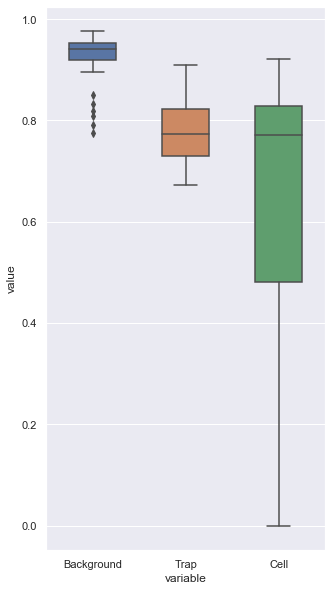

In [138]:
sns.set(rc={'figure.figsize':(5, 10)})
sns.boxplot(x="variable", y="value", data=pd.melt(IoU_result), width = 0.5)
#sns.boxplot(IoU_result)

plt.show()

In [196]:
f1_result.head()

,Background,Trap,Cell
0,0.983672,0.928323,NaN
1,0.960732,0.873408,0.649944
2,0.979121,0.917500,NaN
3,0.987024,0.952153,NaN
4,0.883004,0.809347,0.597080


In [197]:
f1_result.describe()

,Background,Trap,Cell
count,34.000000,34.000000,28.000000
mean,0.958203,0.872874,0.804845
std,0.031272,0.039828,0.137733
min,0.873489,0.804281,0.530985
25%,0.958037,0.843976,0.670672
50%,0.969076,0.872617,0.871636
75%,0.975458,0.902168,0.906798
max,0.987654,0.952153,0.959431


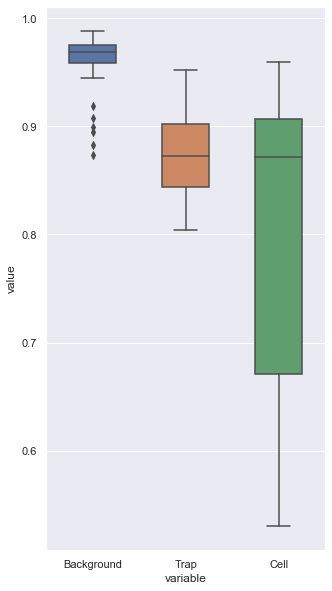

In [198]:
sns.set(rc={'figure.figsize':(5, 10)})
sns.boxplot(x="variable", y="value", data=pd.melt(f1_result), width = 0.5)
#sns.boxplot(IoU_result)

plt.show()